In [1]:
import pandas as pd  
import numpy as np
import sys,glob,os,time
import vaex
import pylab as plt
import seaborn as sea 
import math

import matplotlib as mpl
import matplotlib.cm as cm

import matplotlib.colors as colors
import matplotlib.ticker as mtick
from matplotlib.patches import Circle


import matplotlib.patheffects as path_effects

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


sea.set(font_scale=3,palette=sea.color_palette('colorblind'), 
        rc={'axes.facecolor':'white'})
sea.set_style(style="ticks",rc={"xtick.direction": "in","ytick.direction": "in",
                                "xtick.minor.size": 4, "ytick.minor.size": 4})


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


pi = math.pi
%config IPCompleter.use_jedi = False 

In [2]:
from scipy.special import logsumexp
from scipy.optimize import minimize
from astroML.utils import log_multivariate_gaussian
from xdgmm import XDGMM
import emcee


In [3]:
labels = dict(
    G_RP = 'G - G$_\mathrm{RP}$',
    G_BP = 'G - G$_\mathrm{BP}$',
    BP_RP = 'G$_\mathrm{BP}$ - G$_\mathrm{RP}$',
    Gabs = 'G$_\mathrm{abs}$')


In [4]:
# Opening isochrone
iso = pd.read_table('./isochrones/Mh-1.3_Age13Gyr.dat',
                     comment='#',delim_whitespace=True)

# G,BP,RP,label = iso[['Gmag','G_BPmag','G_RPmag','label']].values.T

iso['G_RP'] = iso['Gmag'] - iso['G_RPmag']
iso['BP_RP'] = iso['G_BPmag'] - iso['G_RPmag']

In [5]:
data_x = np.random.uniform(low=1,high=1.5,size=1000)
data_y = np.random.uniform(low=-5,high=5,size=1000)

In [6]:
mask = (iso['label']==3)
x = iso['BP_RP'][mask]
y = iso['Gmag'][mask]
yy = y+2
s1 = data_y < np.interp(data_x, x,yy)
s2 = data_y > np.interp(data_x, x,y)

In [7]:
def apparent_magnitude(distance, Gabs=iso['Gmag']):
    return Gabs + 5 * np.log10(distance) + 10

In [8]:
def isochrone_mask(d_lower, d_upper, data_x, data_y):
    mask = (iso['label']==3)
    x = iso['BP_RP'][mask]
    y = iso['Gmag'][mask]
    
    yy = apparent_magnitude(d_upper, y)
    y  = apparent_magnitude(d_lower, y)
    
    s1 = data_y < np.interp(data_x, x,yy)
    s2 = data_y > np.interp(data_x, x,y)

    return (s1&s2)



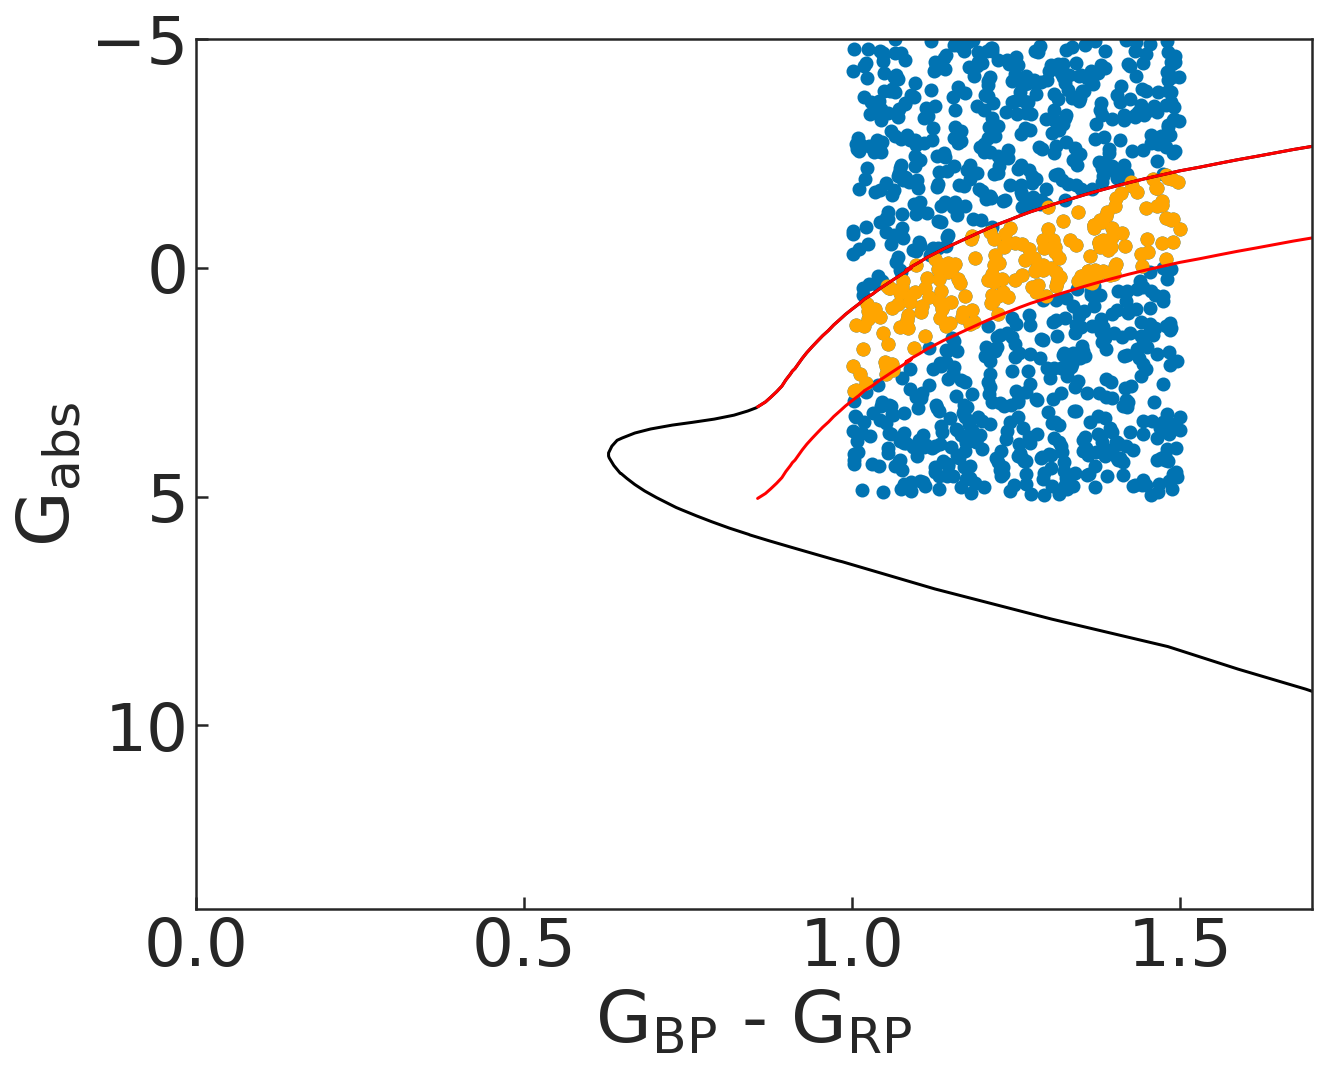

In [9]:
fig,ax = plt.subplots(ncols=1, figsize=(10,8),sharex=True,sharey=True)

mask = isochrone_mask(0.01, 0.02512 ,data_x,data_y)
plt.scatter(data_x,data_y)
# plt.scatter(data_x[s1&s2],data_y[s1&s2], c='orange')
plt.scatter(data_x[mask],data_y[mask], c='orange')



limits = [[0,1.7],[-5,14]]

plt.xlabel(labels['BP_RP'])
plt.ylabel(labels['Gabs'])

plt.xlim(*limits[0])
plt.ylim(*limits[1])
ax.invert_yaxis()



for _ax in [ax]:

    #isochrones
    mask = iso['label']<4
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask],c='k')
    
    mask = (iso['label']==3)
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask],c='r')

    mask = (iso['label']==3)
    _ax.plot(iso['BP_RP'][mask],iso['Gmag'][mask]+2,c='r')

- $G_\mathrm{abs} = m_g - 5\log_{10}{(d)} - 10$
- $H_g = m_g+5\log_{10}(\mu)-10$
- $H_g = G_\mathrm{abs} + 5\log_{10}(\frac{v_\mathrm{tan}}{4.74 (km s^{-1})})$


In [10]:
### Loading data
df = vaex.open('./Antlia2-lb-window-5deg.hdf5')
df['lc'] = df.l - 264.8955
df['bc'] = df.b - 11.2479

In [11]:
def angle_great_circle():
    lrad, brad =  df.lc.deg2rad(), df.bc.deg2rad()

    cosb = brad.cos()
    cosl = lrad.cos()
    
    df['angle'] = (cosb*cosl).arccos().rad2deg()



In [12]:
angle_great_circle()

$
    \cos(\alpha) = \cos(b)\cos(b_c)\cos(l-l_c) + \sin(b)\sin(b_c)
$

With $(l_c, b_c) = (0,0)$ this becomes

$
    \alpha = \arccos(\cos(b)\cos(l))
$

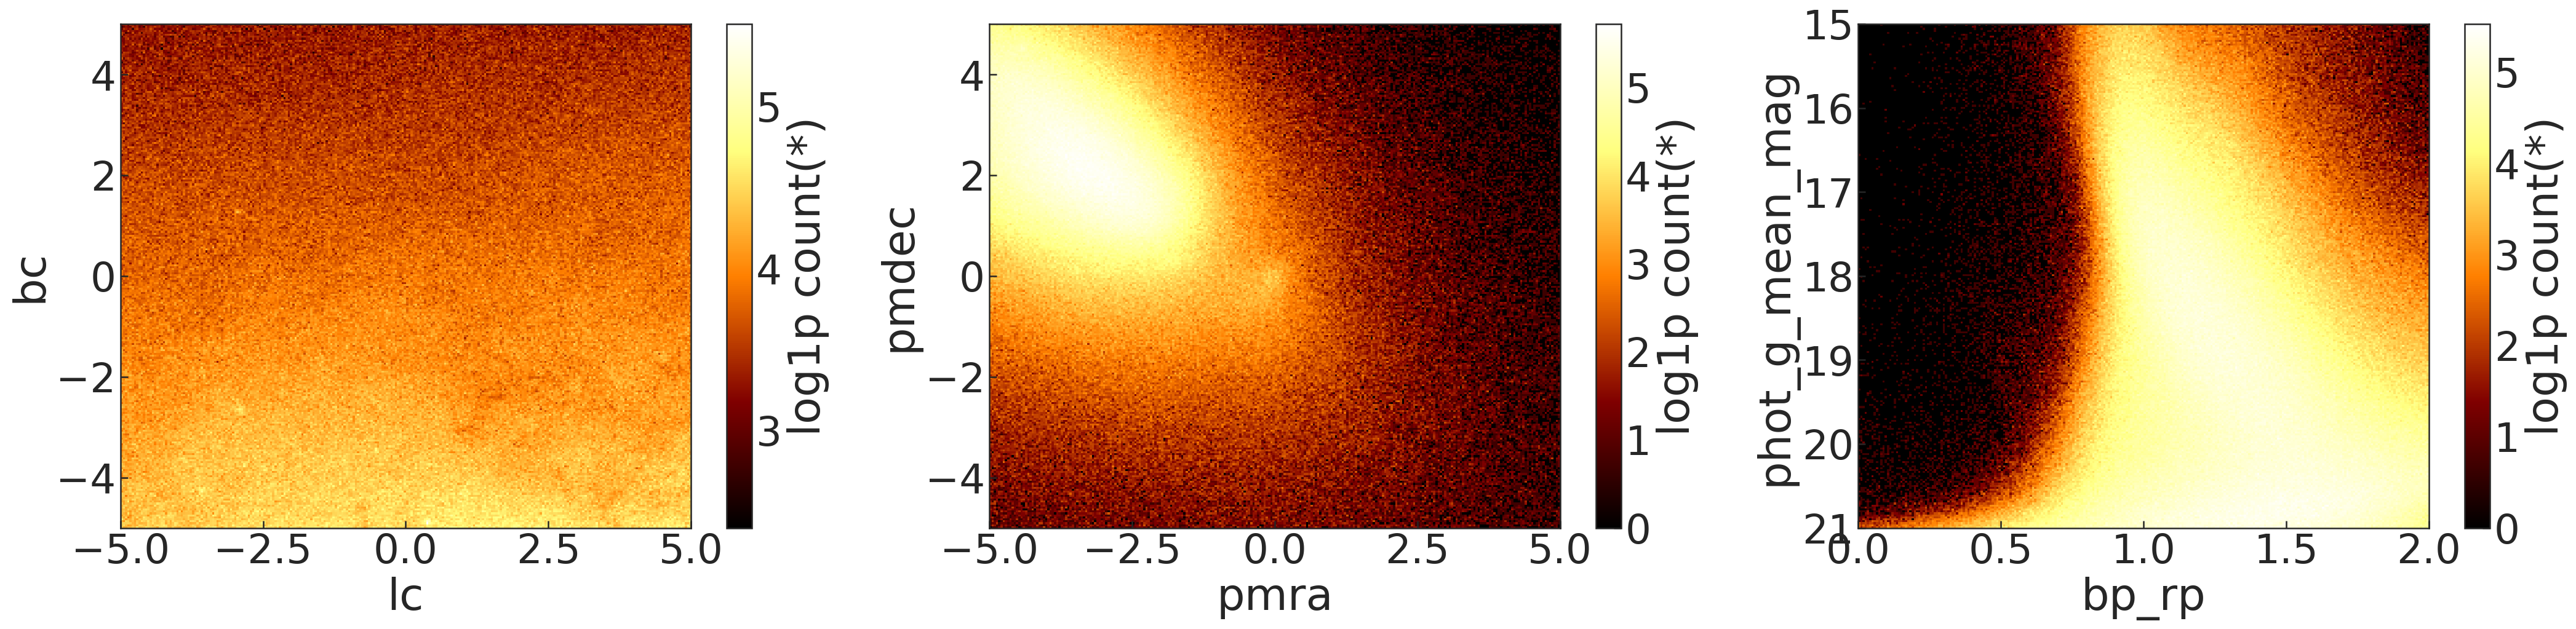

In [13]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection='ruwe<1.4')

plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection='ruwe<1.4')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p')

In [79]:
base_selection = (df.angle<2.5)&(df.parallax<0.25)&(df.ruwe<1.4)
bckg_selection = (df.angle>2.5)&(df.parallax<0.25)&(df.ruwe<1.4)

We start by selecting all Gaia sources within $2^\circ.5$ of the center of Antlia 2 with parallax $\pi\lt 0.25$ mas.

In [15]:
df.count(selection=['',base_selection])

array([3848261,  227221])

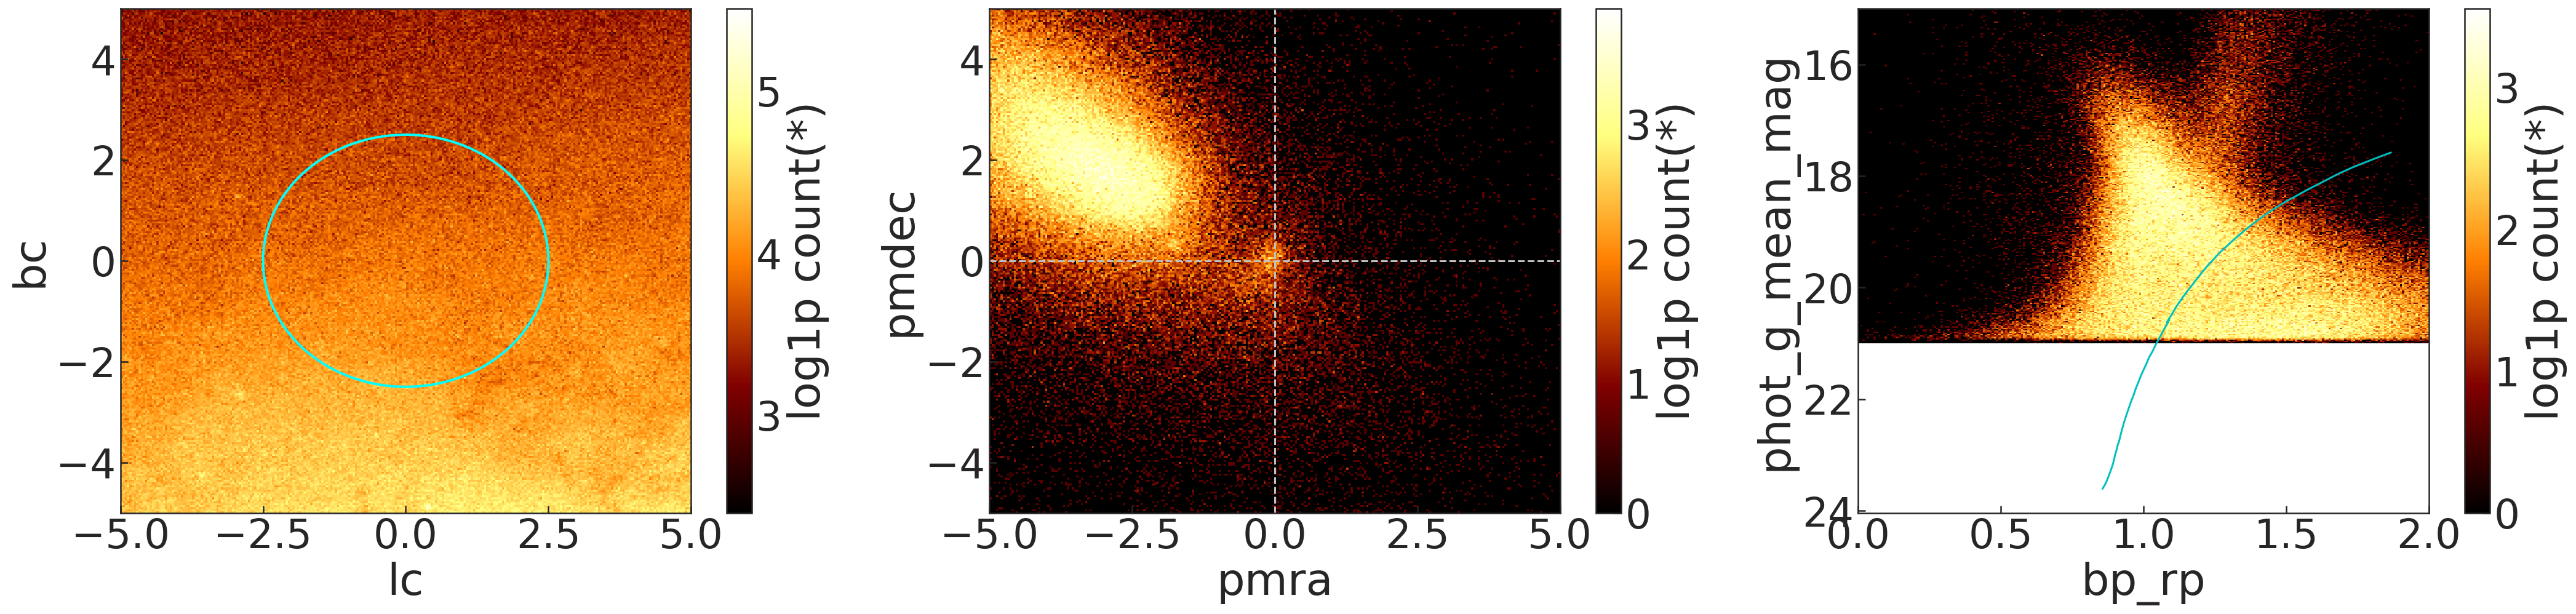

In [16]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection='ruwe<1.4')


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=base_selection)

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(130, iso_Gabs),c='c')

In [118]:
coarse_pm_selection = (df.pmra.abs()<0.5)&(df.pmdec.abs()<0.5)

(21.0, 15.0)

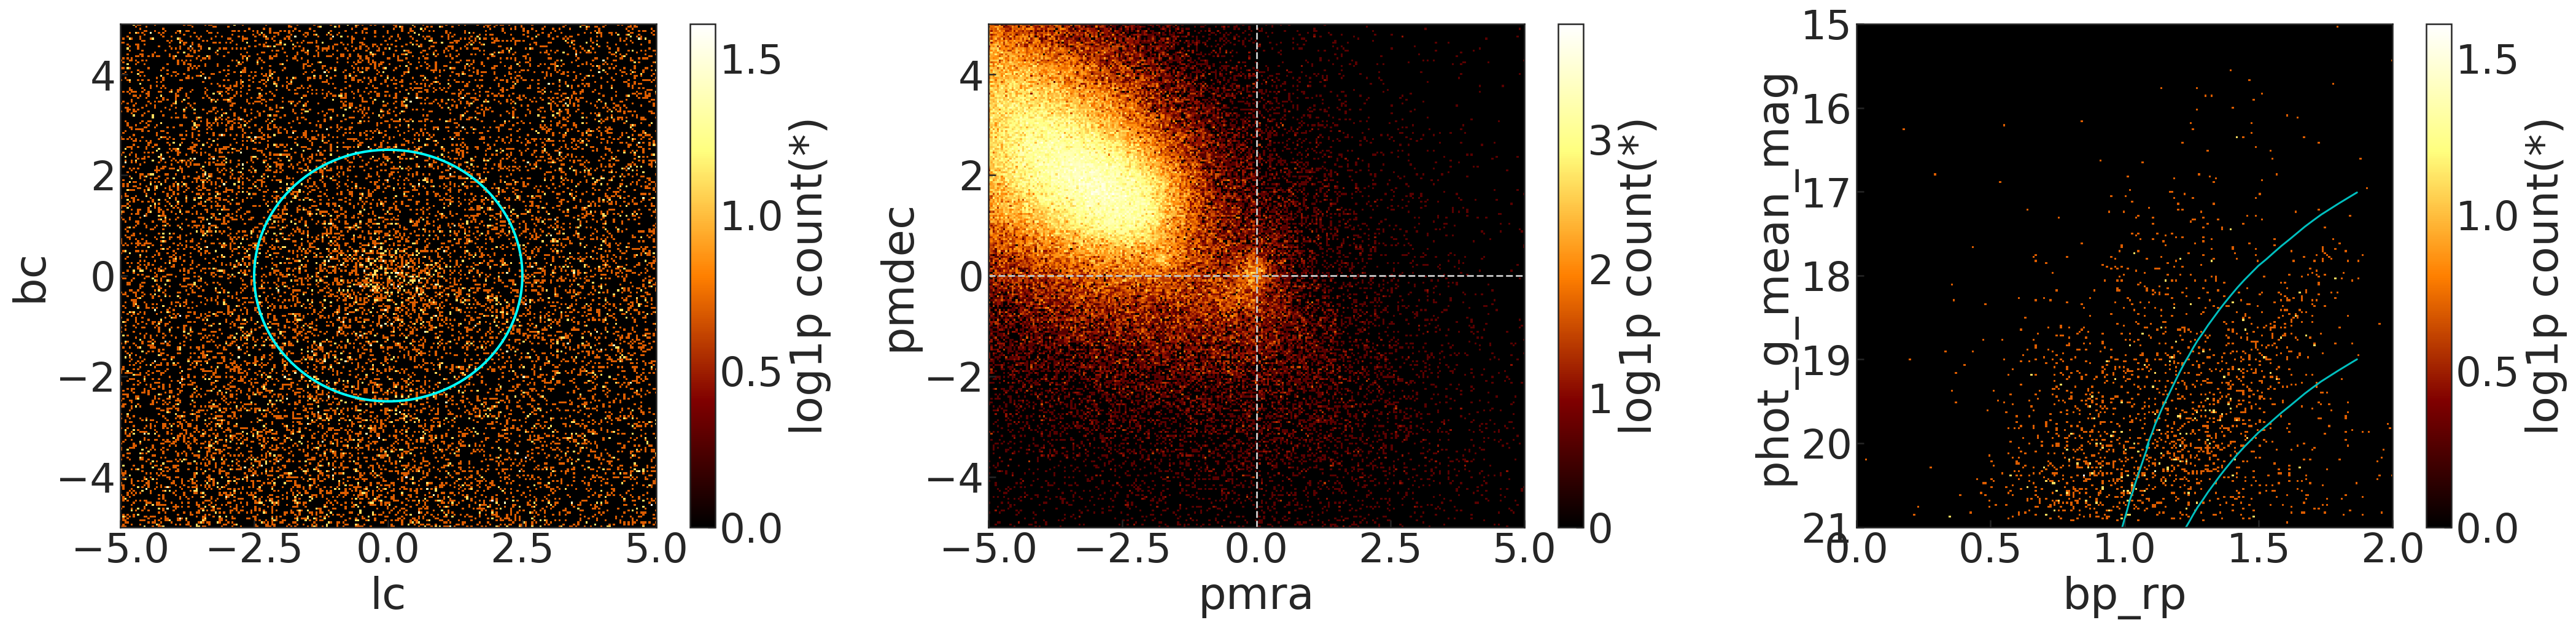

In [18]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4))


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=base_selection)

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

In [61]:
### Adding photometric mask
df['phot_mask'] = isochrone_mask(100,250 ,*df.evaluate(['bp_rp','phot_g_mean_mag']))

(21.0, 15.0)

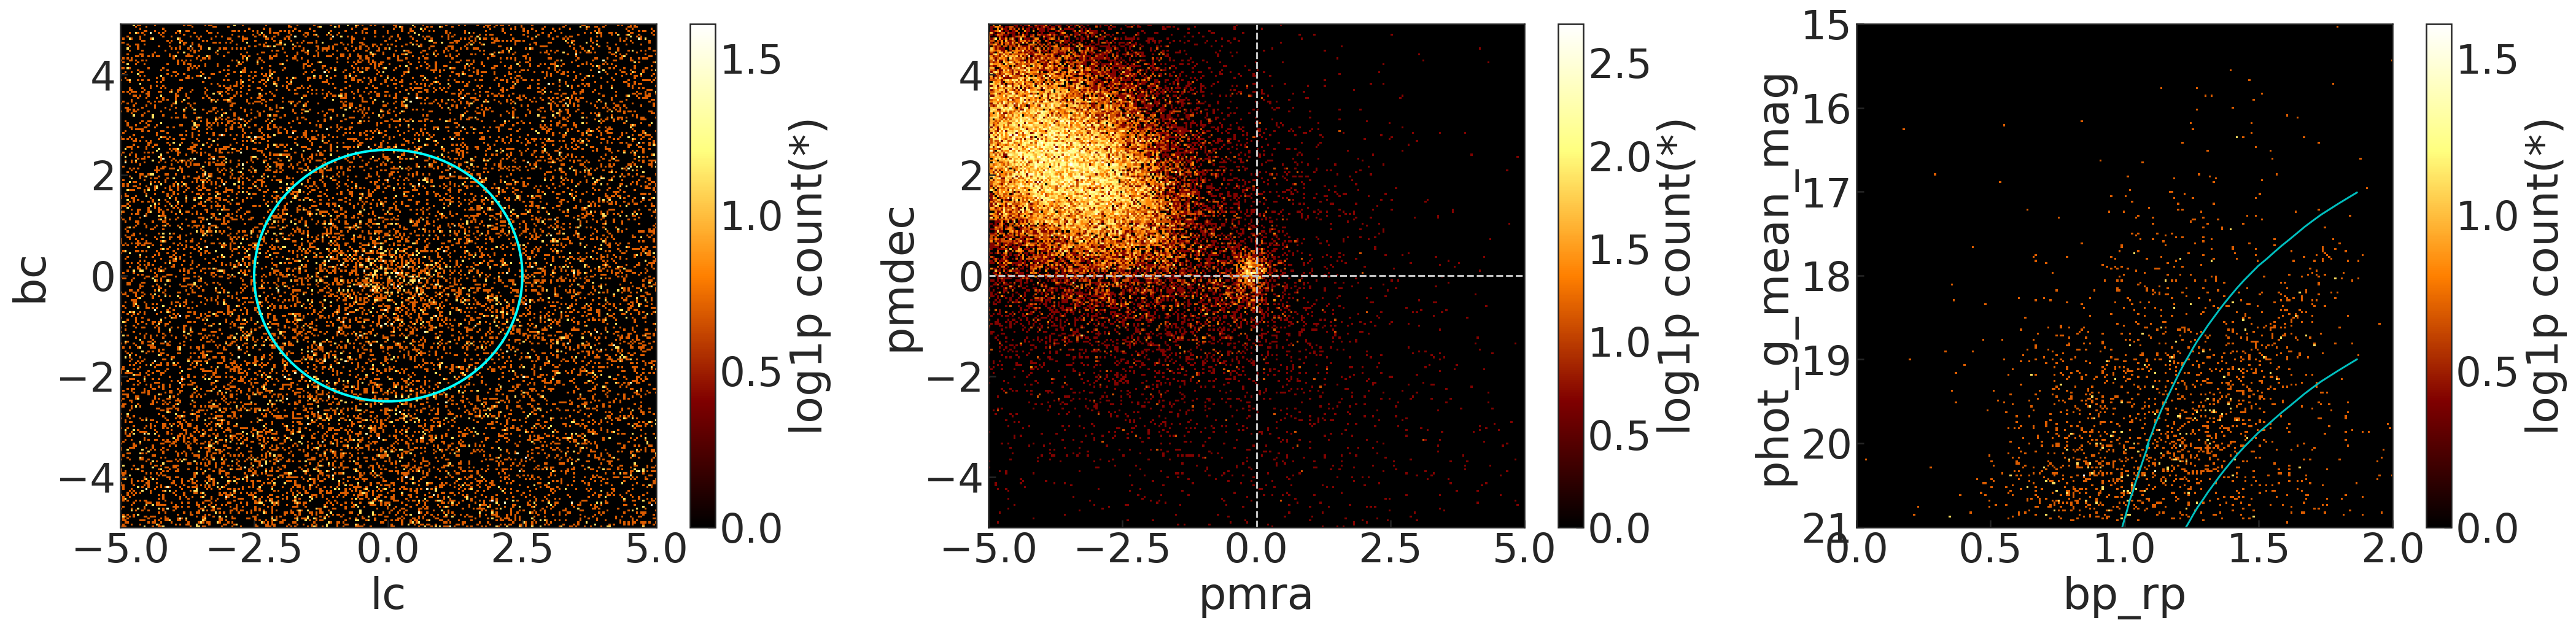

In [62]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4))


circ = Circle([0,0],2.5 , ec='cyan', fc='none', lw=2)
axes[0].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask))

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection)

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

In [63]:
df['mu'] = (df.pmra**2+df.pmdec**2).sqrt()
df['Hg'] = df.phot_g_mean_mag + 5 * (df.mu).log10() - 10

- $G_\mathrm{abs} = m_g - 5\log_{10}{(d)} - 10$
- $H_g = m_g+5\log_{10}(\mu)-10$
- $H_g = G_\mathrm{abs} + 5\log_{10}(\frac{v_\mathrm{tan}}{4.74 (km s^{-1})})$



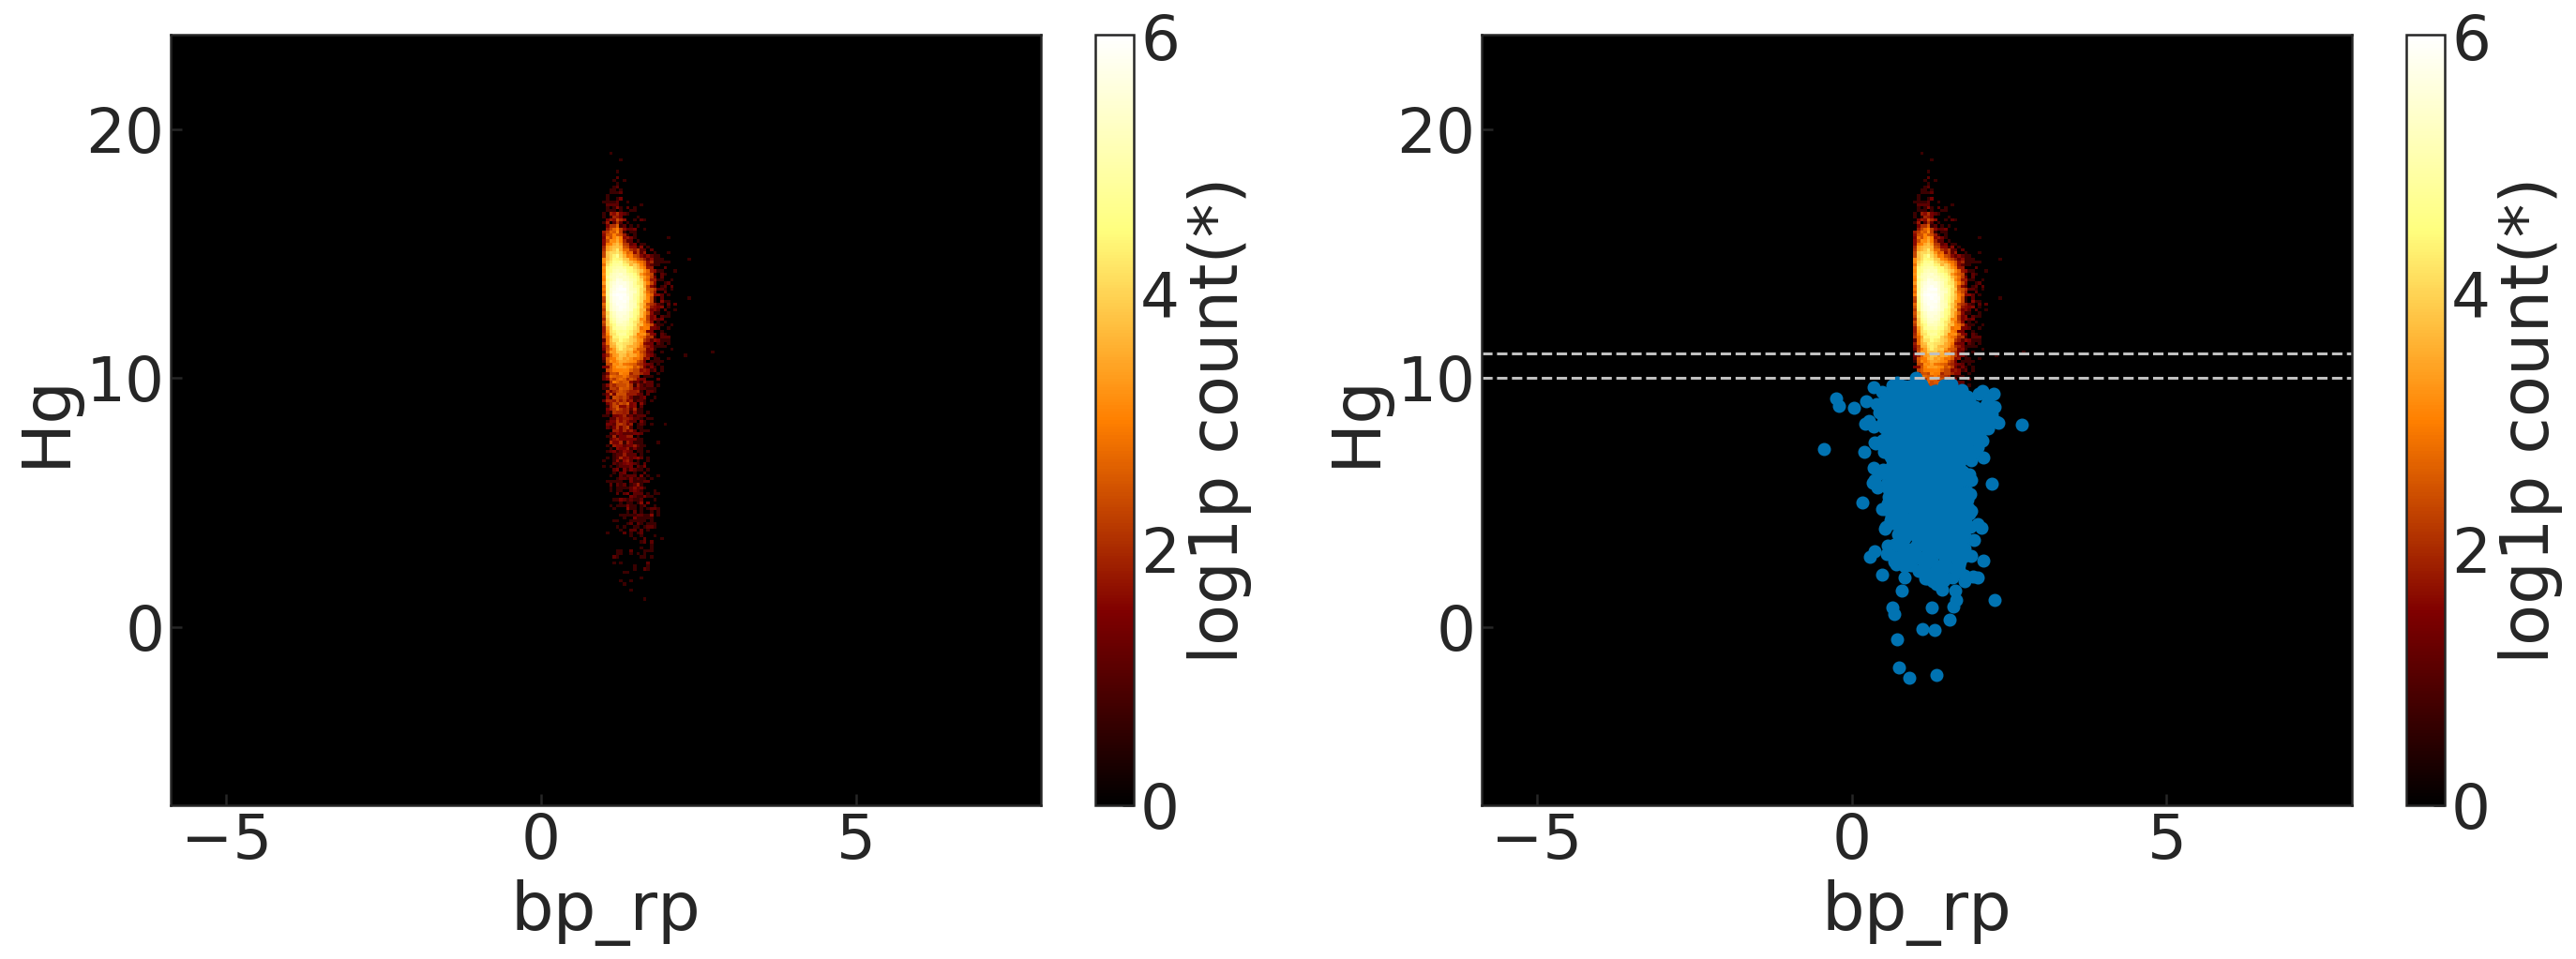

In [64]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))


plt.sca(axes[0])
df.plot('bp_rp','Hg', selection=(base_selection)&(df.phot_mask), f='log1p')


plt.sca(axes[1])
df.plot('bp_rp','Hg', selection=(base_selection)&(df.phot_mask), f='log1p')
df.scatter('bp_rp','Hg', selection=base_selection&coarse_pm_selection)
axes[1].axhline(10, ls='--',c='silver')
axes[1].axhline(11, ls='--',c='silver')

(21.0, 15.0)

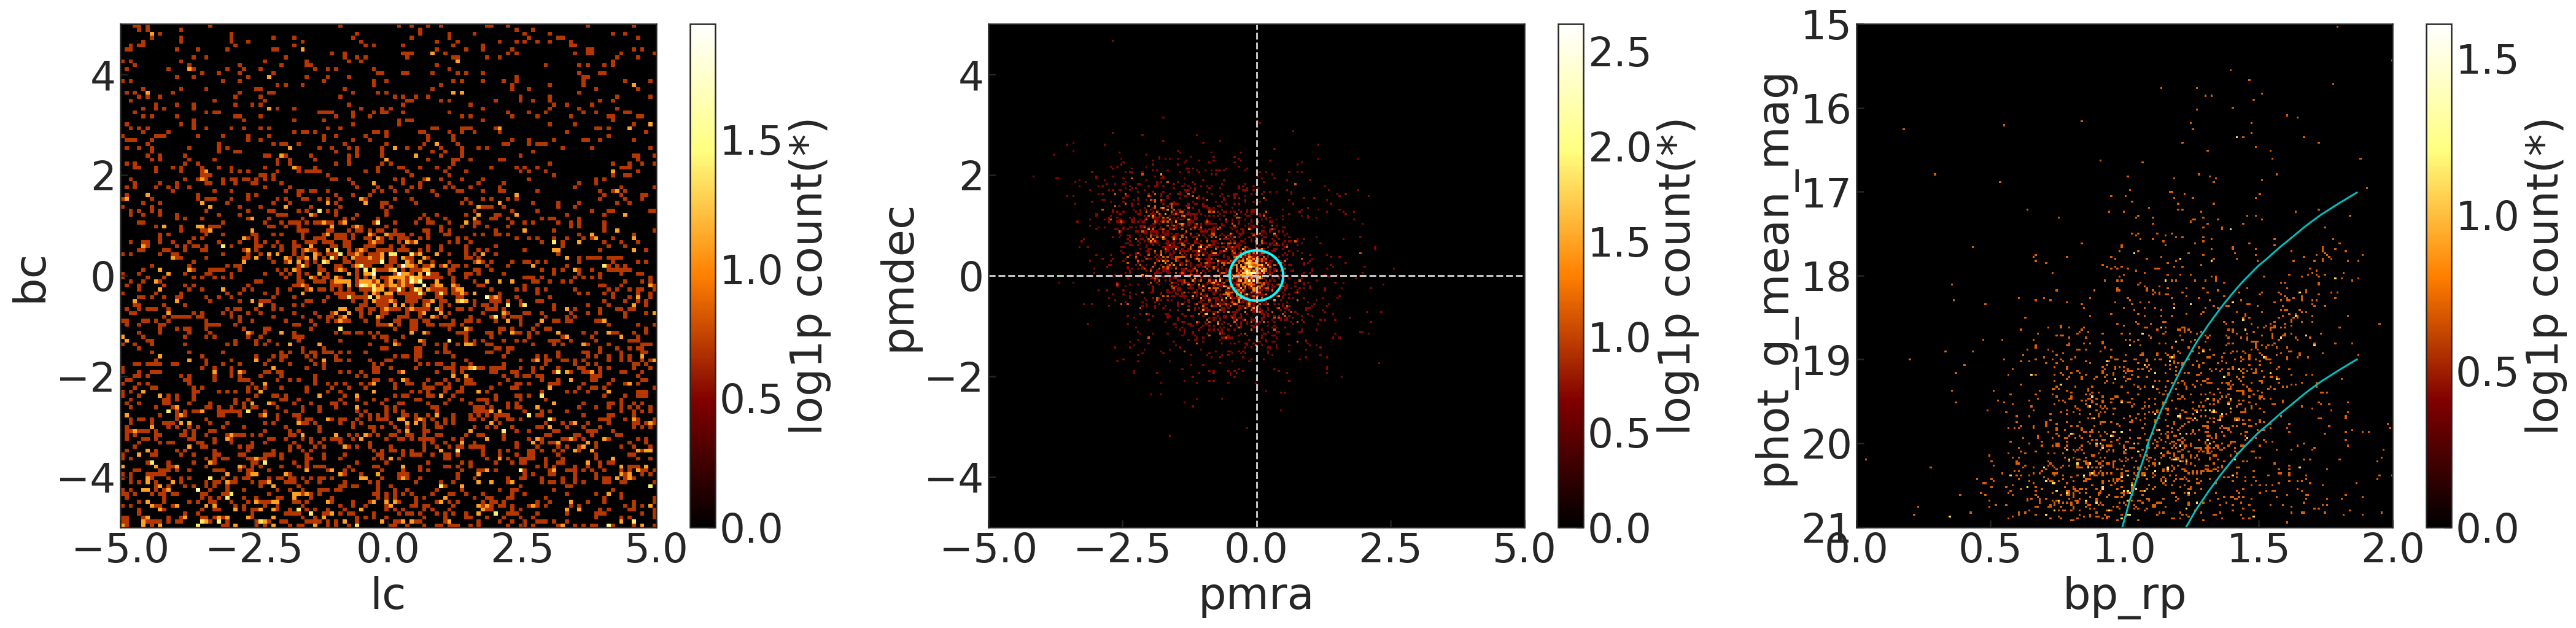

In [122]:
fig, axes = plt.subplots(figsize=(30,8), ncols=3)

plt.sca(axes[0])
df.plot('lc','bc', limits=[-5,5], f='log1p', selection=(coarse_pm_selection)&(df.ruwe<1.4)&(df.Hg<11)&(df.phot_mask), shape=128)


circ = Circle([0,0],0.5 , ec='cyan', fc='none', lw=2)
axes[1].add_patch(circ)




plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

plt.axvline(0, ls='--', c='silver')
plt.axhline(0, ls='--', c='silver')

plt.sca(axes[2])
df.plot('bp_rp','phot_g_mean_mag', limits=[[0,2],[21,15]],f='log1p', selection=base_selection&coarse_pm_selection&(df.Hg<11))

mask = (iso['label']==3)
iso_Gabs = iso['Gmag'][mask]
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

# axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(100, iso_Gabs),c='c')
# axes[2].plot(iso['BP_RP'][mask],apparent_magnitude(250, iso_Gabs),c='c')

axes[2].set_ylim(21,15)

In [123]:
df.count(selection=(base_selection)&(coarse_pm_selection)&(df.Hg<11)&(df.phot_mask))

array(829)

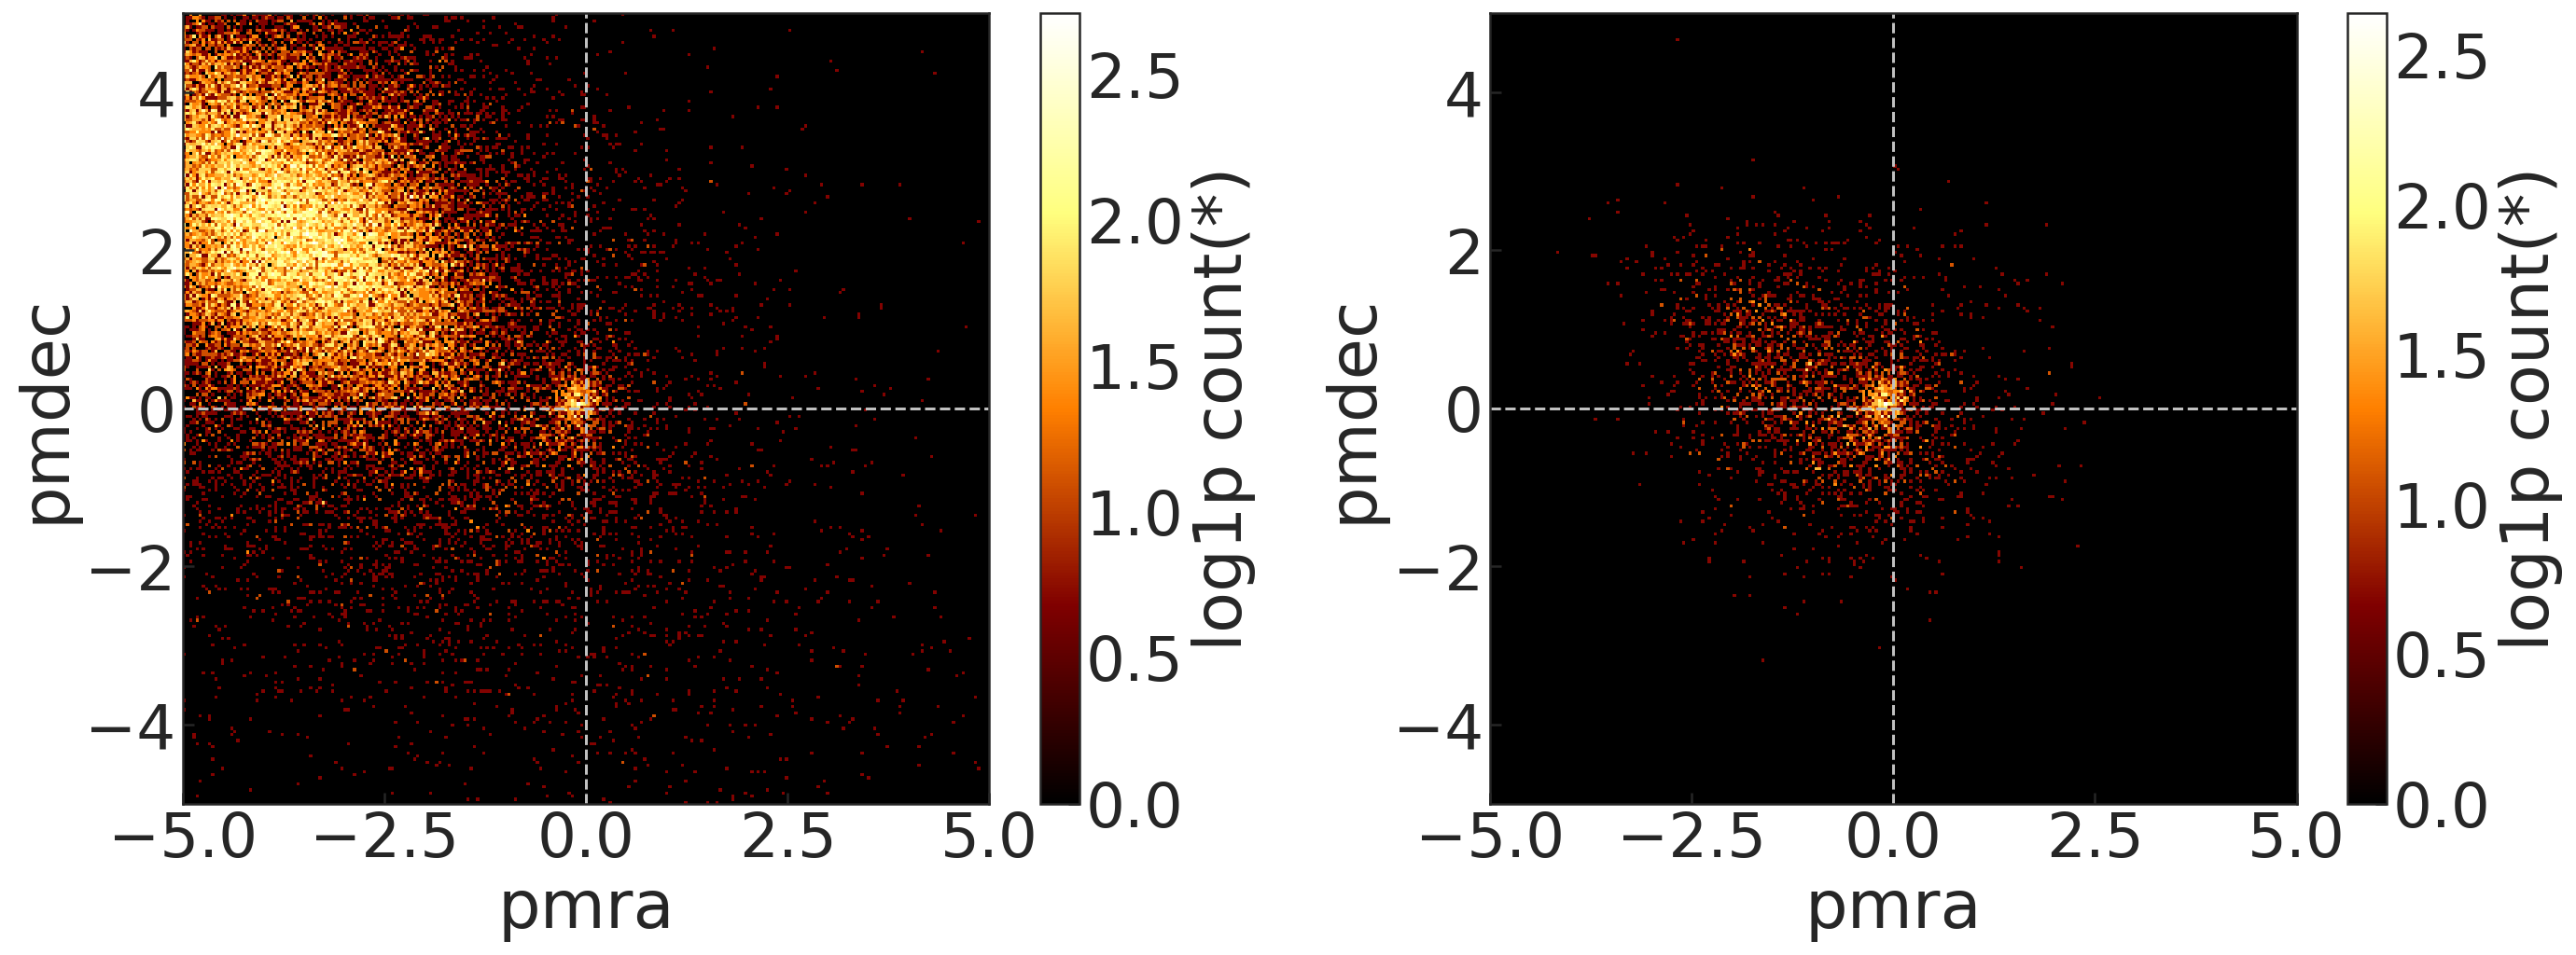

In [91]:
### Inferring Antlia 2's proper motion with XD

fig, axes = plt.subplots(ncols=2, figsize=(20,8))

plt.sca(axes[0])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask))

plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask)&(df.Hg<11))

for ax in axes:
    ax.axvline(0, ls='--', c='silver')
    ax.axhline(0, ls='--', c='silver')

In [87]:
base_selection = (df.angle<2.5)&(df.parallax<0.25)&(df.ruwe<1.4)
bckg_selection = (df.angle>5)&(df.parallax<0.25)&(df.ruwe<1.4)

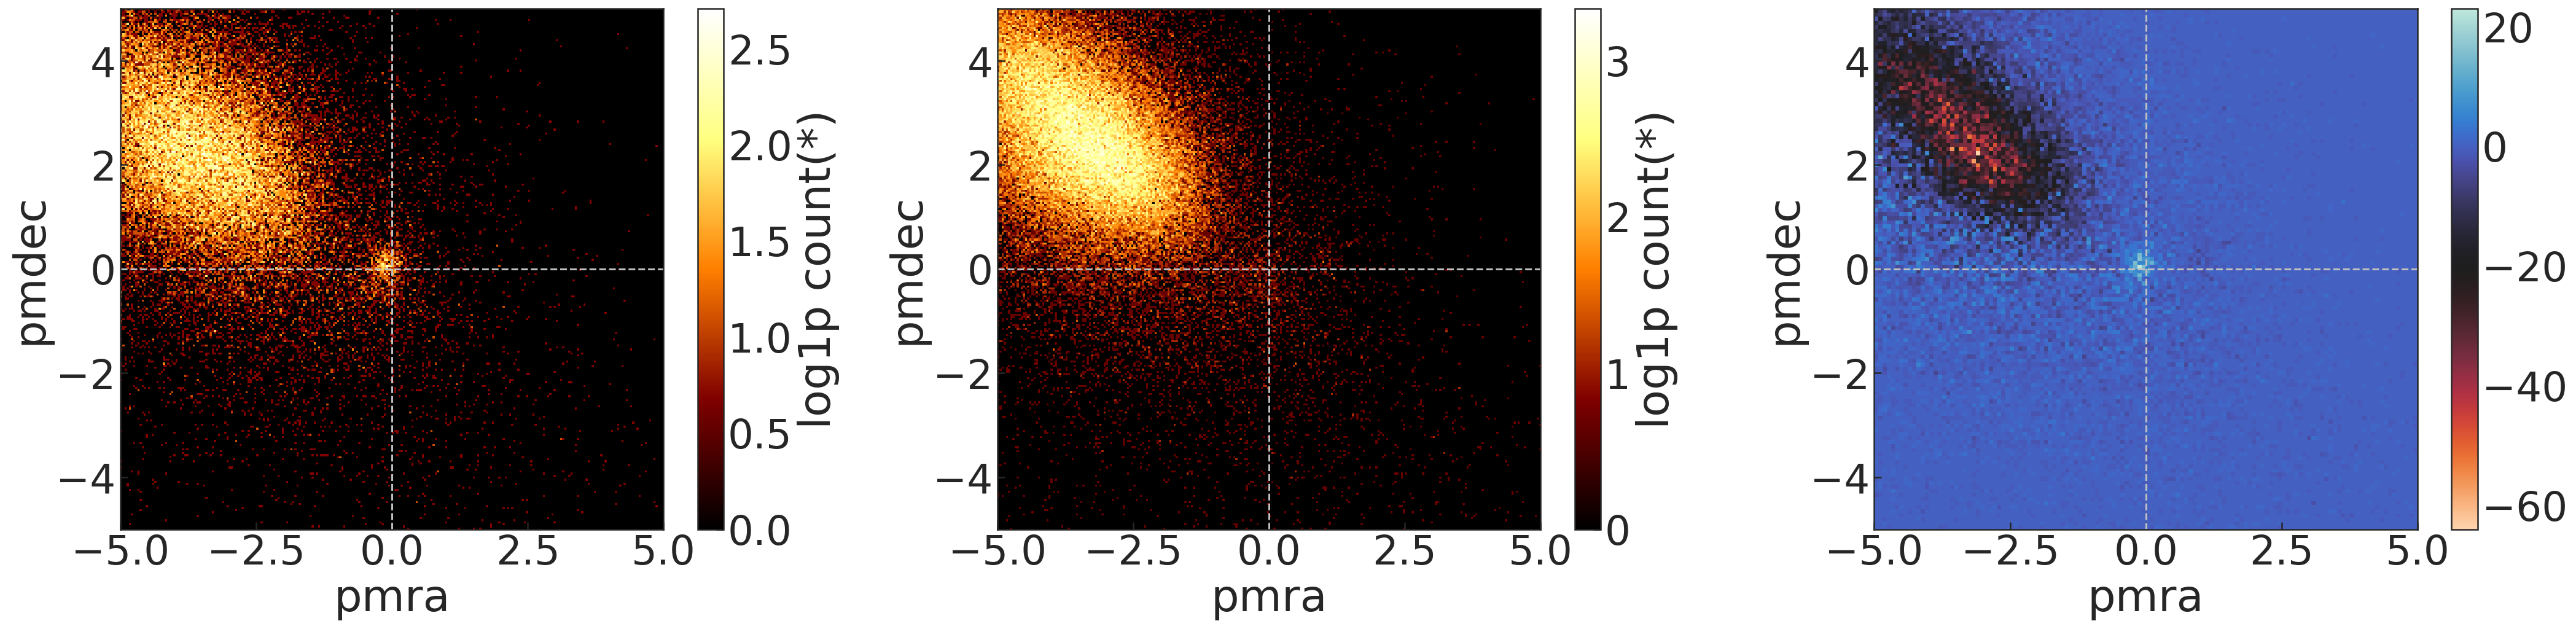

In [95]:
### Inferring Antlia 2's proper motion with XD

fig, axes = plt.subplots(ncols=3, figsize=(30,8))

plt.sca(axes[0])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(base_selection)&(df.phot_mask))
H_cl = df.count(binby=['pmra','pmdec'], limits=[-5,5], selection=(base_selection)&(df.phot_mask))

plt.sca(axes[1])
df.plot('pmra','pmdec', limits=[-5,5],f='log1p', selection=(bckg_selection)&(df.phot_mask))
H_bg = df.count(binby=['pmra','pmdec'], limits=[-5,5], selection=(bckg_selection)&(df.phot_mask))

plt.sca(axes[2])
df.plot('pmra','pmdec', limits=[-5,5],grid=(H_cl-H_bg), colormap='icefire_r')



for ax in axes:
    ax.axvline(0, ls='--', c='silver')
    ax.axhline(0, ls='--', c='silver')

In [96]:
df.count(selection = [(base_selection)&(df.phot_mask),
                      (bckg_selection)&(df.phot_mask)])

array([54112, 97716])

In [98]:
X_cl = np.array(df.evaluate(['pmra','pmdec'] ,
                             selection=(base_selection)&(df.phot_mask))).T

Cov_cl = np.array(df.evaluate(['pmra_error**2','pmra_error*pmdec_error*pmra_pmdec_corr',
                              'pmra_error*pmdec_error*pmra_pmdec_corr','pmdec_error**2'] ,
                             selection=(base_selection)&(df.phot_mask))).T.reshape(-1,2,2)


X_bg = np.array(df.evaluate(['pmra','pmdec'] ,
                             selection=(bckg_selection)&(df.phot_mask))).T

Cov_bg = np.array(df.evaluate(['pmra_error**2','pmra_error*pmdec_error*pmra_pmdec_corr',
                              'pmra_error*pmdec_error*pmra_pmdec_corr','pmdec_error**2'] ,
                             selection=(bckg_selection)&(df.phot_mask))).T.reshape(-1,2,2)

In [99]:
optimal_n_comp = 5
gmm = XDGMM(n_components=optimal_n_comp, method='Bovy', 
            random_state=np.random.RandomState(42),
            n_iter=2048)
_ = gmm.fit(X_bg, Cov_bg)

In [100]:
_.mu

array([[-3.8131064 ,  1.29658222],
       [-2.9985364 ,  2.11716497],
       [-3.69410416, -0.90865548],
       [-4.29663465,  3.43107896],
       [-4.70907401,  4.24515017]])

(-20.0, 20.0)

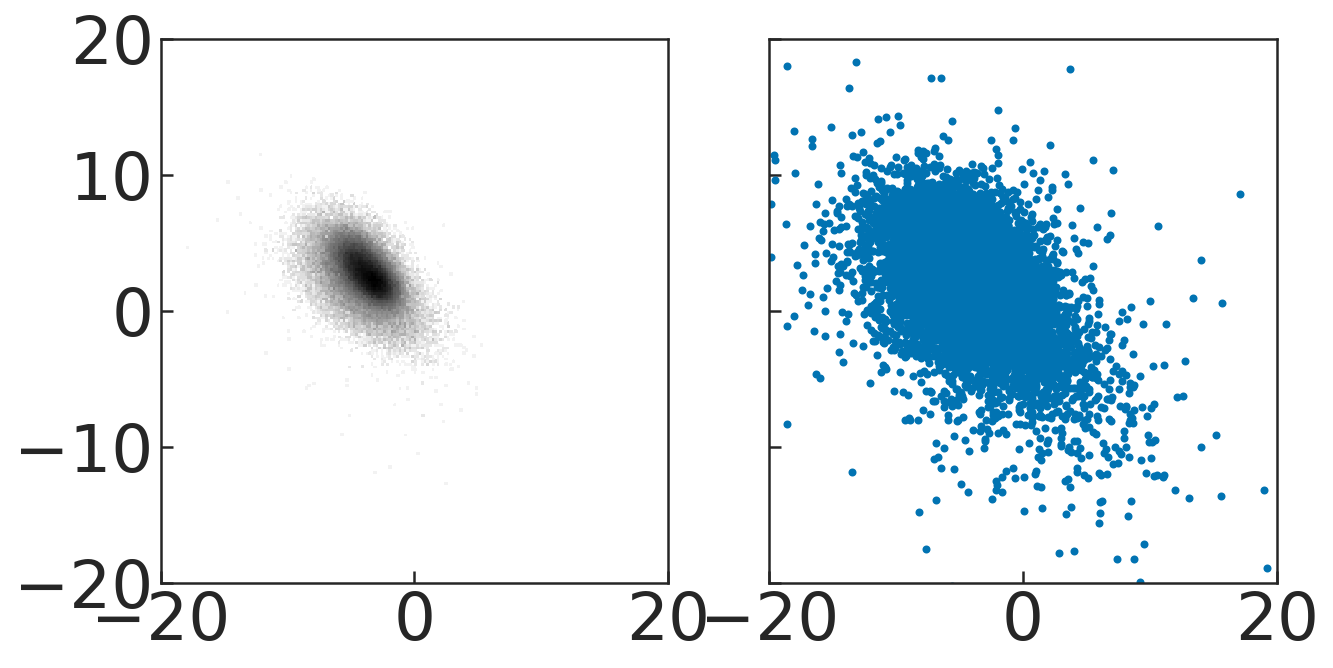

In [101]:
test = gmm.sample(size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(test[:, 0], test[:, 1], bins=np.arange(-20, 20+1e-3, 0.2))
ax.pcolormesh(xe, ye, H_test.T, norm=mpl.colors.LogNorm(), cmap='Greys')

ax = axes[1]
ax.plot(X_bg[:, 0], X_bg[:, 1], marker='.', ls='none', alpha=1)

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

In [102]:
def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

def ln_prior(p):
    x, y, lns, lnf = p
    
    lp = 0
    
    if x < -5 or x > 5 or y < -5 or y > 5:
        return -np.inf
    
    lp += ln_normal(lns, -1, 5)
    lp += -lnf
    
    return lp

def ln_likelihood(p, gmm, X, Cov):
    x, y, lns, lnf = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    mu = np.array([[x, y]])
    V = np.array([[[s, 0],
                   [0, s]]]) ** 2
    
    T = Cov + V
    logproba = log_multivariate_gaussian(X, mu, T)
    
    ll1 = bg_prob + np.log(1-f)
    ll2 = logproba + np.log(f)
    
    return np.logaddexp(ll1, ll2).sum(), (ll1, ll2)

def ln_posterior(p, *args):
    lnp = ln_prior(p)
    if not np.isfinite(lnp):
        return -np.inf #, None

    lnl, blob = ln_likelihood(p, *args)
    if not np.isfinite(lnl):
        return -np.inf # , None

    return lnp + lnl# , blob

In [103]:
faster_gmm = XDGMM(n_components=gmm.n_components, 
                   mu=gmm.mu, V=gmm.V, weights=gmm.weights, 
                   method='astroML')

In [104]:
bg_prob = logsumexp(faster_gmm.logprob_a(X_cl, Cov_cl), axis=-1)

In [105]:
p0 = (-0.095, 0.058, np.log(0.2), np.log(0.1))
res = minimize(lambda *args, **kwargs: -ln_likelihood(*args, **kwargs)[0],
               x0=p0, args=(faster_gmm, X_cl, Cov_cl), method='L-BFGS-B')
print('done optimize', res)

done optimize       fun: 224836.1702513509
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.38708095,  0.31141099, -0.01164153,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([-0.11205478,  0.06358261, -2.53368674, -3.93963413])


In [ ]:
# 4-comp: pmra, pmdec = (-0.099 +- 0.043), (0.100 +- 0.045)
# 3-comp: pmra, pmdec = (-0.100 +- 0.046), (0.082 +- 0.073)

# Chakrabarti+2019:
# (ma cosd, md) = (-0.068, 0.032)  (0.023, -0.031) mas yr-1.

In [106]:
%%time
ln_likelihood(p0, faster_gmm, X_cl, Cov_cl)

CPU times: user 2.02 s, sys: 19.9 ms, total: 2.04 s
Wall time: 2.02 s


(-227080.65511874767,
 (array([-2.5252936 , -4.36499604, -4.50174273, ..., -2.7658823 ,
         -5.45005304, -5.5116391 ]),
  array([ -26.75799765,  -19.2204623 ,  -72.13021431, ..., -207.38508593,
         -132.84104242,   -9.33869129])))

In [109]:
from schwimmbad import MultiPool

In [110]:
nwalkers = 32
# pp0 = p0
pp0 = res.x
all_p0 = emcee.utils.sample_ball(pp0, [1e-3]*len(pp0), size=nwalkers)

with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, len(pp0), ln_posterior,
                                    args=(faster_gmm, X_cl, Cov_cl),
                                    pool=pool)
    pos, *_ = sampler.run_mcmc(all_p0, 128, progress=True)
    sampler.reset()
    pos, *_ = sampler.run_mcmc(pos, 128, progress=True)
    
# print('done burn-in')
# sampler.reset()
# pos, prob, state, blobs = sampler.run_mcmc(pos, 256, progress=True)

100%|██████████| 128/128 [11:41<00:00,  5.48s/it]


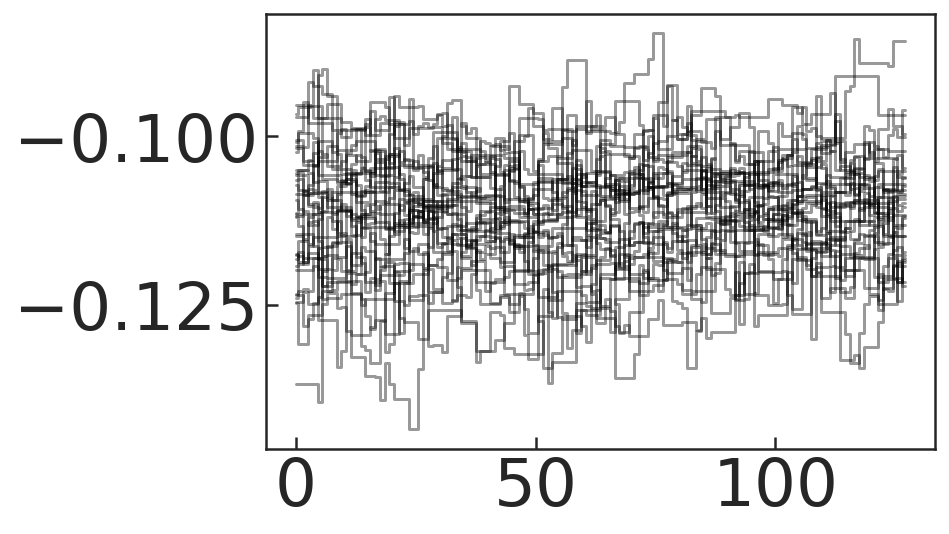

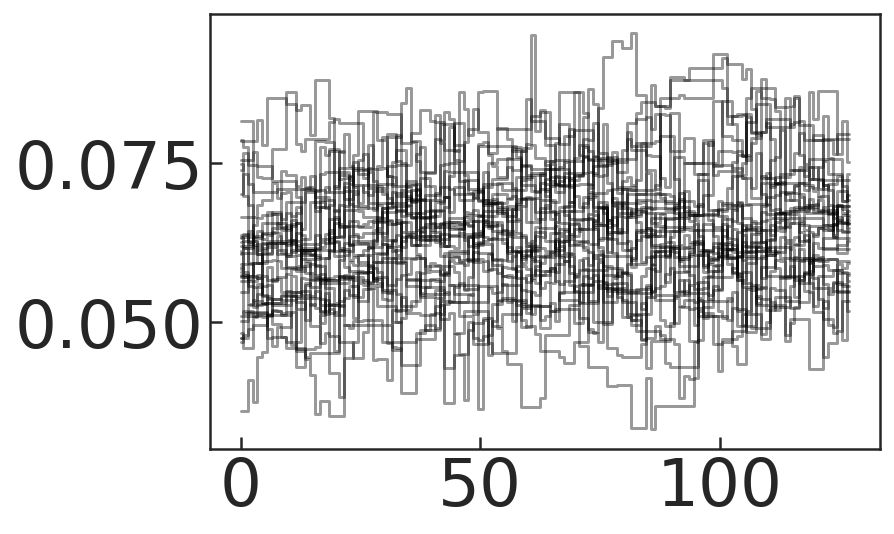

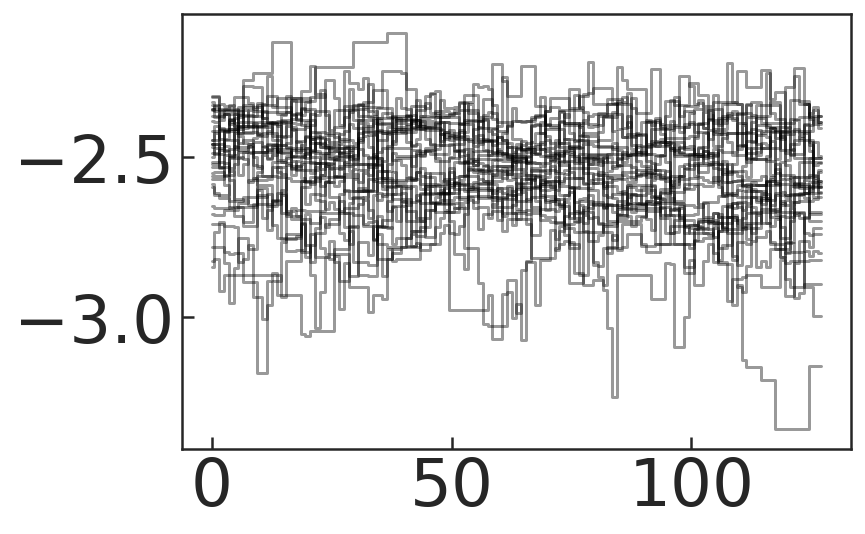

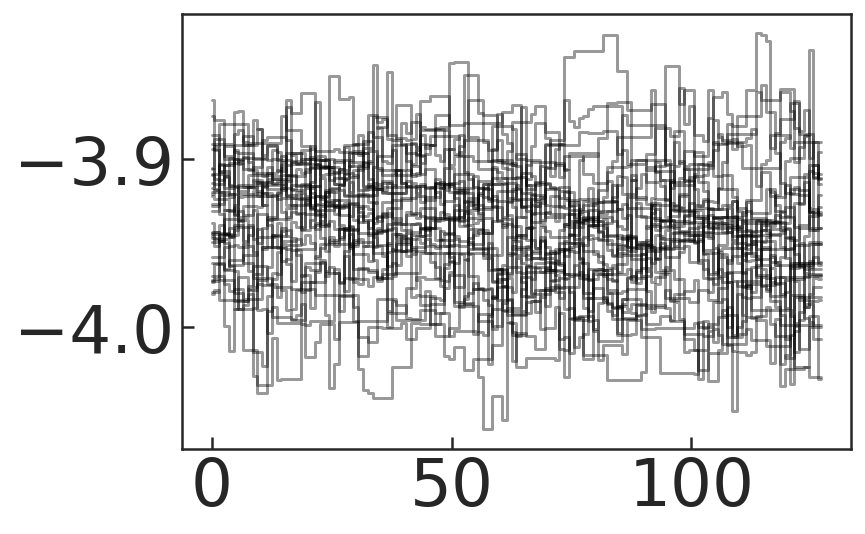

In [111]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, drawstyle='steps-mid', marker='', alpha=0.4, color='k')

In [112]:
flatchain = np.vstack(sampler.chain[:, 64:])

In [113]:
np.mean(flatchain, axis=0)

array([-0.11075244,  0.064708  , -2.56555133, -3.94612712])

In [114]:
np.std(flatchain, axis=0)

array([0.00803358, 0.01030478, 0.16013746, 0.03861043])

In [ ]:
Adrians code; Gaia EDR3:
(ma cosd, md) = (-0.111, 0.065) +-  (0.008, 0.010) mas yr-1

Chakrabarti+2019:
(ma cosd, md) = (-0.068, 0.032) +- (0.023, -0.031) mas yr-1.

Torrealba+2019:
(ma cosd, md) = (-0.095, 0.058) +- (0.018, -0.024) mas yr-1.



In [ ]:
# HHK XDGMM estimates:
# 4-comp: pmra, pmdec = (-0.099 +- 0.043), (0.100 +- 0.045)
# 3-comp: pmra, pmdec = (-0.100 +- 0.046), (0.082 +- 0.073)